# ポルトガルのリスボンにある卸売業者が顧客から集めたデータ分析

## 教師なし学習とは何か?

教師なし学習はあるルールに基づいてデータをグループ分けする手法です。データに正解ラベルがない学習方法です。

教師あり学習の**分類問題**と似ているようですが、分類問題が分類するべき答えとなる**教師データ（ラベル）**を学習に使い、
未知のデータに対してそのデータのラベル予測するのに対し、教師なし学習はその名の通り教師データがありません。

教師なし学習ではアルゴリズムに従ってデータを分類しますが、その分類が何かを答えるわけではなくただ分類するだけです。

では教師なし学習は何に使えるのでしょうか？

大きく２つの用途があります。

- クラスタリング
    - データのぱっと見では分からない関連性や類似性を見つけ出すために使われる。

- 次元削減
    - 前処理として他機械学習の精度をあげる。
    - 前処理として他機械学習の高速化に貢献できる。
    - 人間が理解できる2,3次元に削減することでデータを可視化できる。


たとえばユーザの商品の購入データからおすすめ商品を提示するレコメンドシステムに使えます。
このレコメンドにはユーザの性別、年齢などの分類ではなく購入履歴から同じような商品を買っている人をグルーピングし、そのグループは同じ嗜好を
持っていると考えられるため、同じグループの別の人たちが購入した商品をレコメンドするといった使われ方をします。

いずれの用途にせよ教師なし学習は答えがないため人間の解釈が必要となることが難しさであり、面白さにも繋がっています。

教師なし学習の代表的なものは

- Kmeans法
- PCA（主成分分析）

があります。今回はこの２つを使ってクラスタリングを行っていきます。

問題：Wholesale customers Data Set
[ポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータ](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)を
使用します。

顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっていて、このデータを教師なし学習を使って顧客の傾向を分析していきます。

 ## 必要なライブラリをimport

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

 # データ取得

In [2]:
#csvを読み込むコードを記述
data =pd.read_csv('./Wholesale customers data.csv')

## データを眺める

In [3]:
print("サンプルの数：{} 　特徴量の数：{}\n".format(*data.shape))
print("各特徴量の型\n",data.dtypes,"\n")
print("統計量の要約")
display(data.describe())
display(data.head())

サンプルの数：440 　特徴量の数：8

各特徴量の型
 Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object 

統計量の要約


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


すべて数値データで欠損値はありません。
８項目440データと大きなデータではないのでメモリやマルチプロセッシングなどは考慮しません。

## 不要な特徴量を消す

今回は分類データではなく、顧客の購入データから傾向を分析したいので
ChannelとRegionを除きます。

あとでこの２つのカテゴリーとクラスタリングの結果を比較していきます。

In [5]:
#元のデータはdata_originalに格納しておく
data_original = data.copy()

In [6]:
#dataからChannelとRegionの2列を削除するコードを記述
data=data.drop(['Channel','Region'],axis=1)
display(data.head())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## scatter matrixを描く

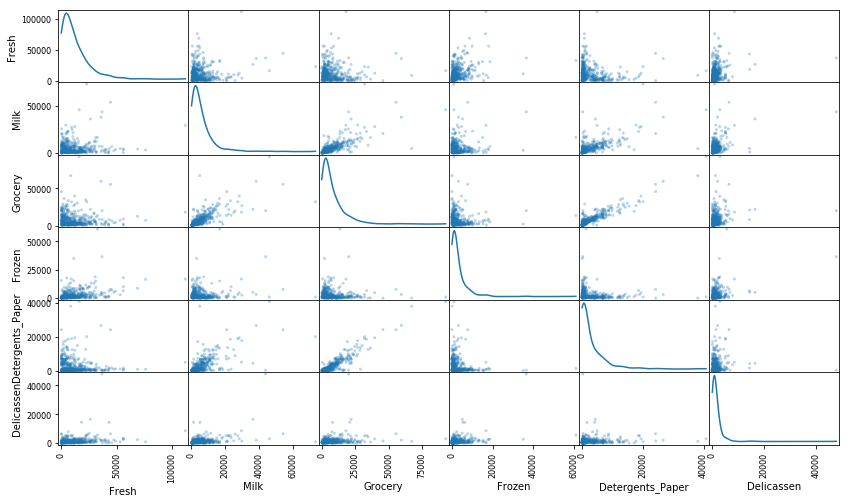

In [7]:
pd.scatter_matrix(data, alpha = 0.3, figsize = (14, 8), diagonal = 'kde');

# Feature Scaling

### なぜFeature Scalingが必要なのか?

散布図を見ると分かりますが、小規模な顧客が多いためプロット結果が左下に偏ってしまっています。

今回の目的はクラスタリング、つまりデータをいくつかの塊に分けて可視化したい。

そのままプロットすると見づらくなってしまうので今回はデータの可視化の観点からフィーチャースケーリングを行う。

今回は値の最小値が１なので対数を取ることで０から１5の範囲に収まるため、フィーチャースケーリングとして対数を取る。

In [8]:
# Feature Scalingの実行
import numpy as np
data_fs=np.log(data)

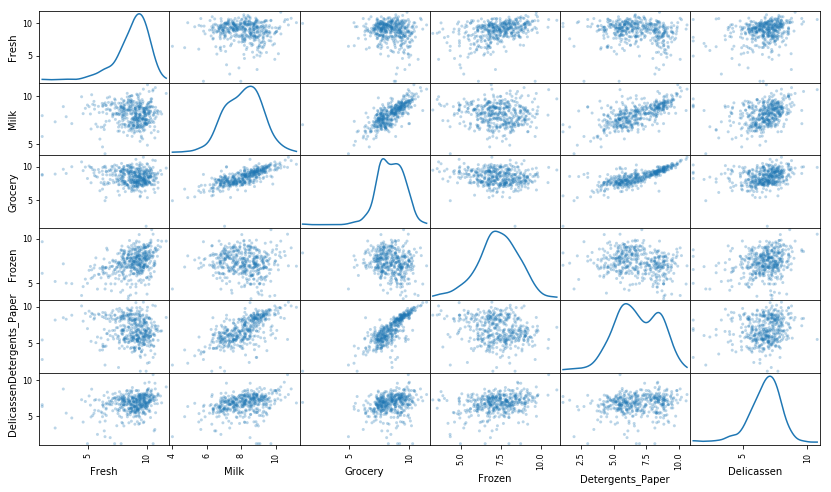

In [9]:
pd.scatter_matrix(data_fs, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# Feature Extraction

## PCAの実行

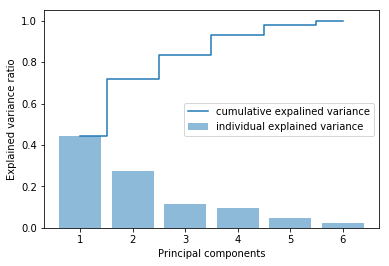

In [10]:
#data_fsに対しPCAを行い分散説明率の累積を確認
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# PCAを施して学習
# pca = PCA(n_components=3)
# data_fs = pca.fit_transform(data_fs)


pca = PCA(n_components=None)
data_pca = pca.fit_transform(data_fs)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [11]:
eigenvectors = pca.components_
print("固有ベクトル")
print(eigenvectors)

固有ベクトル
[[ 0.17371704 -0.394463   -0.45436364  0.17219603 -0.74551495 -0.1494356 ]
 [-0.68513571 -0.16239926 -0.06937908 -0.487691   -0.04191162 -0.50970874]
 [-0.67351166  0.03306794 -0.03218274  0.28481122 -0.21824404  0.64459672]
 [-0.21432619  0.0185577   0.06448674  0.80608348  0.19005006 -0.51348977]
 [-0.00082162  0.72228834  0.34799325 -0.03624337 -0.56366476 -0.19536639]
 [-0.02927638  0.54303508 -0.81390826 -0.0174477   0.20244363 -0.02283197]]


In [12]:
#固有値（各主成分におけるデータの分散）
eigenvalue= pca.explained_variance_
eigenvalue

array([4.83781898, 3.02459061, 1.27047648, 1.05179707, 0.50039796,
       0.25095302])

In [13]:
(eigenvalue[0] + eigenvalue[1]) / np.sum(eigenvalue)

0.7189452317370728

第２主成分で７０％超えていることが確認できた。

In [14]:
#分散説明率が70%を超える数の主成分を選び、data_pcaに格納する
data_pca= eigenvectors[0:2]
data_pca

array([[ 0.17371704, -0.394463  , -0.45436364,  0.17219603, -0.74551495,
        -0.1494356 ],
       [-0.68513571, -0.16239926, -0.06937908, -0.487691  , -0.04191162,
        -0.50970874]])

## なぜPCAを行うのか？

PCAは機械学習の前処理として用いられることが多い。

その理由として下記２点が挙げられる。

- 次元削減により、クラスタリングで使用する次元を絞込み、可視化しやすくするため。
- 一般的には次元削減を行ってより少ない特徴数にすることで学習の精度や高速化を行うため。


## クラスタリングとは何か？

**クラスタリング**とはデータの集合をクラスタという部分集合に分ける手法。

隠れたグループや関係性を発見することが目的で、ECサイトのレコメンデーションや商品開発のターゲット層を見つけ出すのに使われる。

 階層的手法は関係や距離が近いものから順番に組み合わせていくので階層によって任意のクラスターに分けることができる。
 
 非階層的手法は分ける数を指定して分割を行う手法ですべての距離を計算する必要がないので大規模なデータをさっと分けたいときに用いられます。デメリットとして開始点がランダムに決まるため結果が変わることがあるので再現性が求められる場面では用いられない。
 
 またクラス分類とクラスタリングは名前こそ似ているが、クラス分類は正解データがあるのに対し、クラスタリングは正解がなく分類数も人間の主観で決めることができる。正解がないため、出てきたパターンから人間が解釈を行ってアクションにつなげる必要があります。

In [15]:
data_fs.columns

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')

In [16]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(data_fs, metric='euclidean')))#, columns=['Fresh', 'Milk'])
print(row_dist)

          0         1         2         3         4         5         6    \
0    0.000000  2.228506  3.088862  4.370853  3.335270  1.310767  1.647395   
1    2.228506  0.000000  1.542136  3.265387  1.989303  1.362980  2.176584   
2    3.088862  1.542136  0.000000  3.432707  1.651791  2.295854  3.342786   
3    4.370853  3.265387  3.432707  0.000000  2.407488  3.264068  3.560555   
4    3.335270  1.989303  1.651791  2.407488  0.000000  2.412860  3.235635   
5    1.310767  1.362980  2.295854  3.264068  2.412860  0.000000  1.561235   
6    1.647395  2.176584  3.342786  3.560555  3.235635  1.561235  0.000000   
7    2.333955  0.781000  1.337492  2.907066  1.699507  1.492109  2.111804   
8    1.599339  2.094442  3.139531  3.410168  3.259593  1.245439  1.008493   
9    2.347990  1.169375  1.922346  4.240870  2.747458  2.108975  2.523150   
10   3.499069  1.479770  1.955458  3.412324  2.578349  2.673123  2.996408   
11   3.458258  3.243439  4.047937  1.980645  3.299428  2.688773  2.348229   

## 樹状図を描く

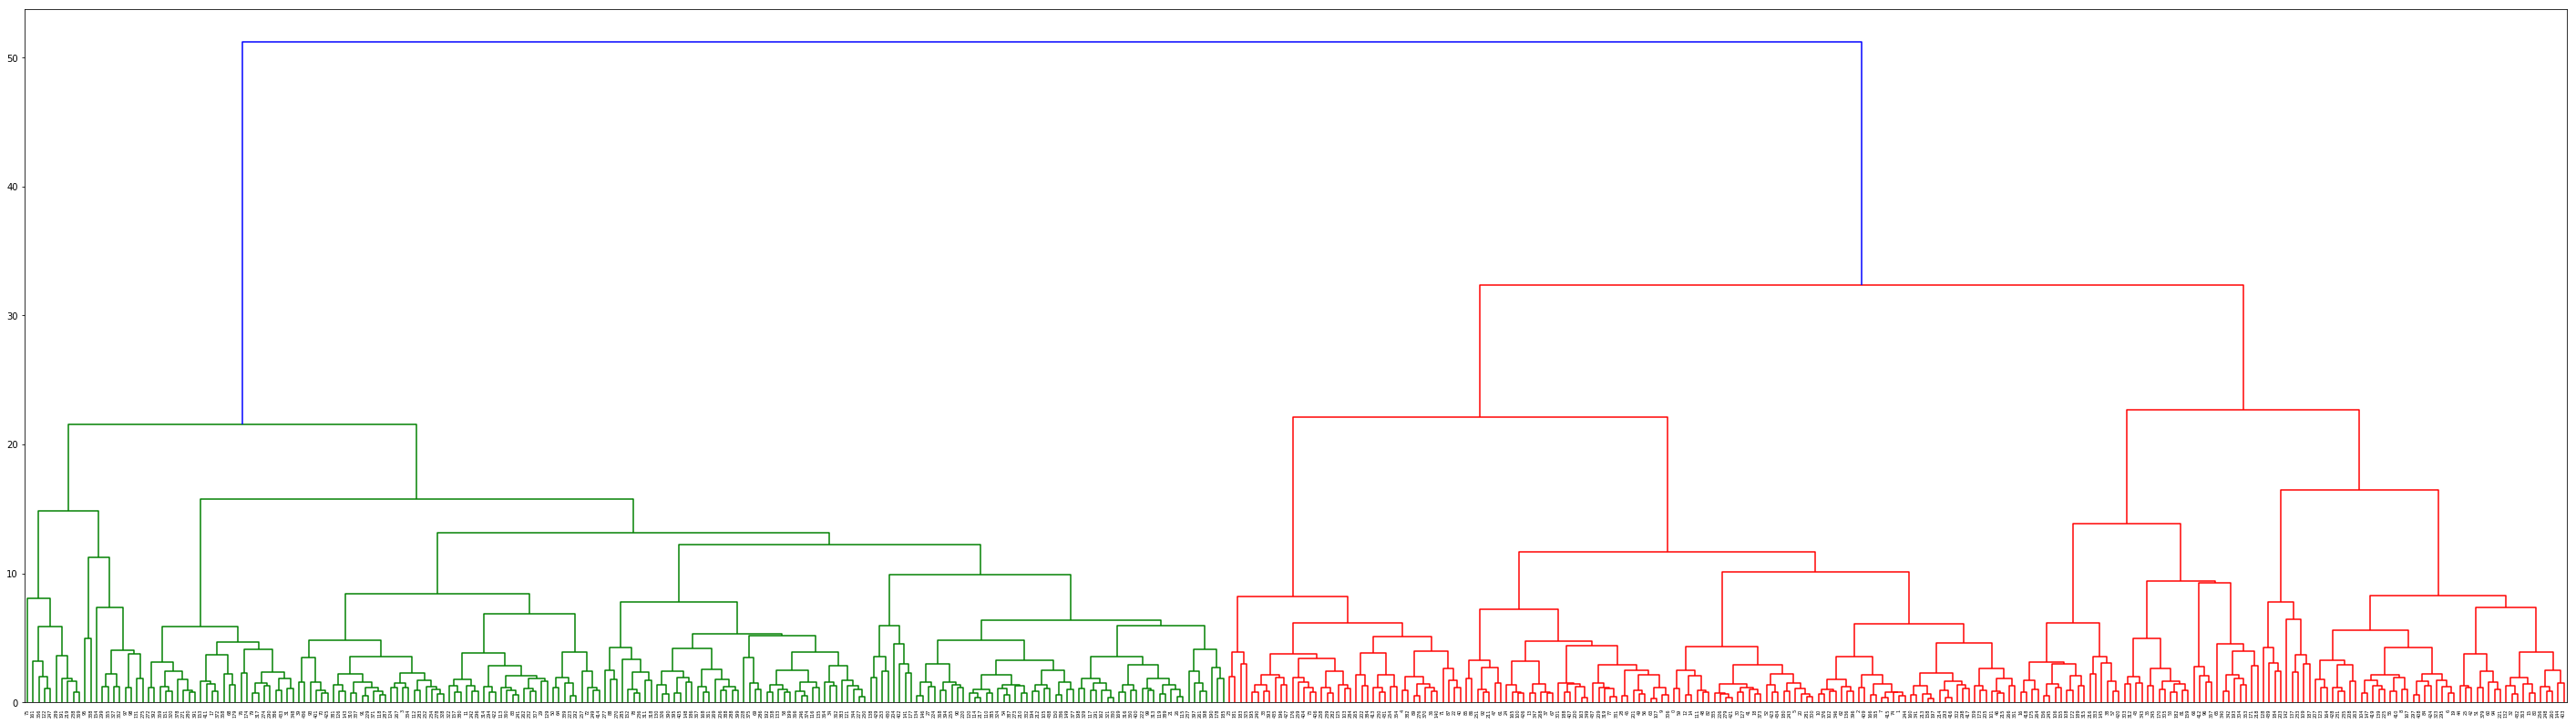

In [17]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

#ward法を使う

plt.figure(figsize=(50,14))
#row_clusters = linkage(pdist(data_fs, metric='euclidean'), method='complete')
row_clusters = linkage(data_fs, method='ward')
row_dender = dendrogram(row_clusters)#, labels=name)

plt.show()

 ## k-meansにおけるkの値の検討
  ### エルボー法

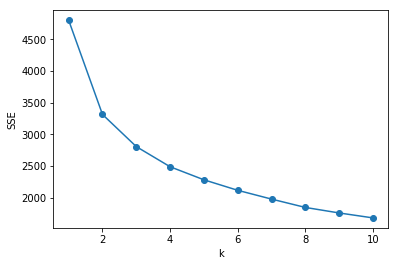

In [18]:
#クラスタ数を検討するためのコードを記述
#エルボー法
from sklearn.cluster import KMeans

SSE = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    km.fit(data_fs)
    SSE.append(km.inertia_)

plt.plot(range(1,11), SSE, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

### シルエット分析

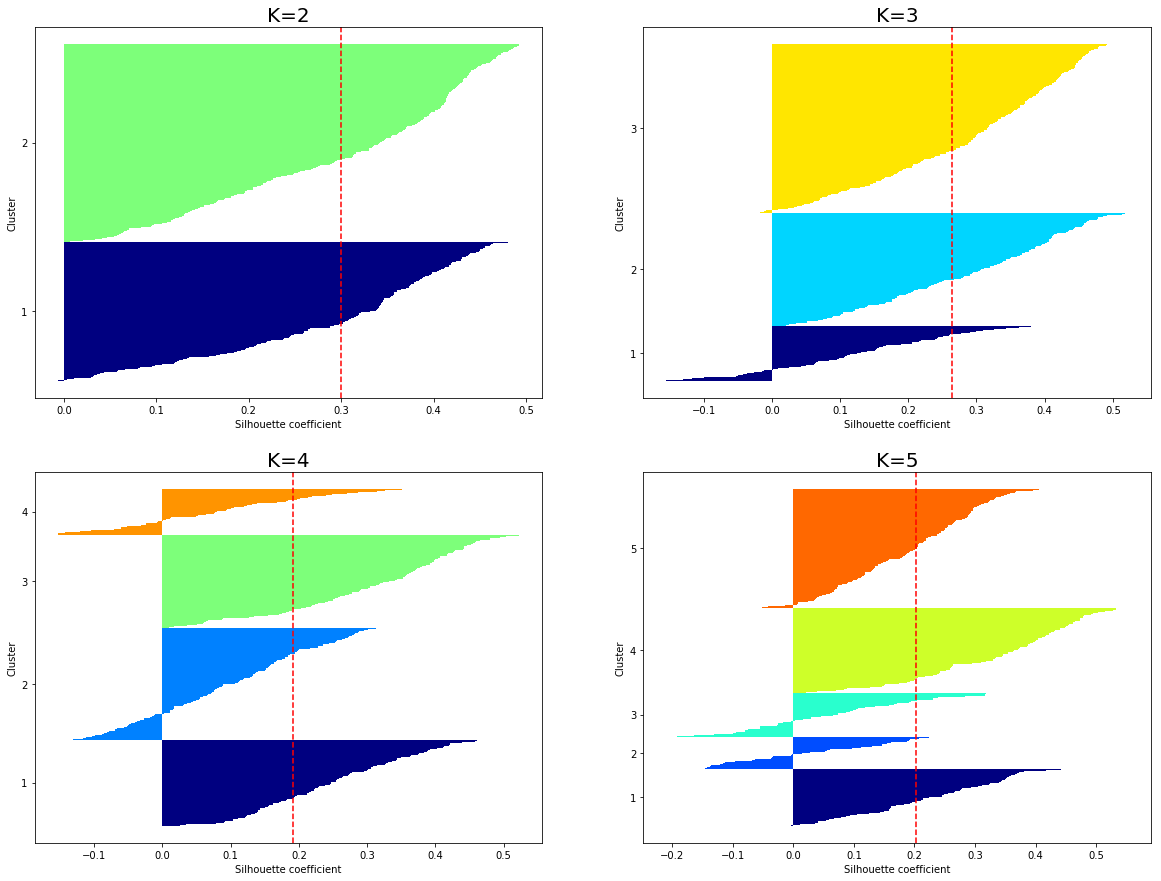

In [19]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples
import numpy as np

plt.figure(figsize=(20,15))
for j in range(2,6):
    plt.subplot(2,2,j-1)
    km = KMeans(n_clusters=j, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(data_fs)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data_fs, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title('K='+str(j),fontsize=20)
plt.show()


k=2  

理由：

エルボー法の図から、k=2からk=3にかけての傾きがk=2までのそれよりも若干緩やかに変化していることが確認できる。

シルエット分析もn_clusters=2にしたときに２つの帯が平均シルエット係数を超えており、かつ厚みがほぼ同じである。

この２手法から今回は**k＝２**が妥当だと考えた。

## k-meansの実行

In [20]:
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(data_fs)

## クラスタリングの可視化



In [21]:
#散布図を描くコードを記述
#中心点もプロットする
pca_vector = data_pca
pca_vector

array([[ 0.17371704, -0.394463  , -0.45436364,  0.17219603, -0.74551495,
        -0.1494356 ],
       [-0.68513571, -0.16239926, -0.06937908, -0.487691  , -0.04191162,
        -0.50970874]])

In [22]:
data_pca = np.dot( data_fs, pca_vector.T)

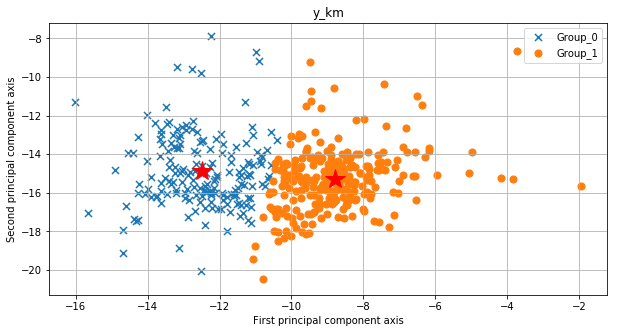

In [23]:
plt.figure(figsize =(10,5))
plt.title('y_km')

data_zero = data_pca[y_km==0]
data_one = data_pca[y_km==1]

# plt.scatter(data_pca[:,0], data_pca[:,1], c=y_km , marker='o', s=50)
plt.scatter(data_zero[:,0], data_zero[:,1], marker='x', s=50, label='Group_0')
plt.scatter(data_one[:,0], data_one[:,1], marker='o', s=50, label='Group_1')
plt.grid()
plt.hold(True)
centroid = np.dot(km.cluster_centers_, pca_vector.T)
plt.plot(centroid[:,0], centroid[:,1], "*", MarkerSize =20, MarkerFaceColor = 'r', MarkerEdgeColor = 'r')
plt.legend()
plt.xlabel("First principal component axis")
plt.ylabel("Second principal component axis")
plt.show()

### 既知のグループとの比較

最初に省いたRegion、Channelグループも可視化して比較を行う。


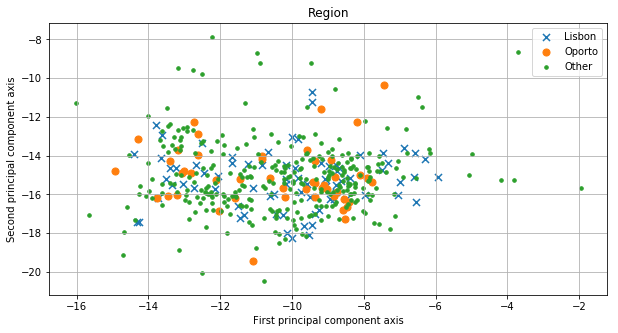

In [24]:
plt.figure(figsize =(10,5))
plt.title('Region')

data_Lisbon= data_pca[data_original["Region"]==1]
data_Oporto = data_pca[data_original["Region"]==2]
data_Other = data_pca[data_original["Region"]==3]

plt.scatter(data_Lisbon[:,0], data_Lisbon[:,1], marker='x', s=50, label='Lisbon')
plt.scatter(data_Oporto[:,0], data_Oporto[:,1], marker='o', s=50, label='Oporto')
plt.scatter(data_Other[:,0], data_Other[:,1],marker='.', s=50, label='Other')

plt.grid()
# plt.hold(True)
#centroid = np.dot(km.cluster_centers_, pca_vector.T)
#plt.plot(centroid[:,0], centroid[:,1],"*", MarkerSize =20, MarkerFaceColor = 'r', MarkerEdgeColor = 'r')
plt.xlabel("First principal component axis")
plt.ylabel("Second principal component axis")
plt.legend()
plt.show()

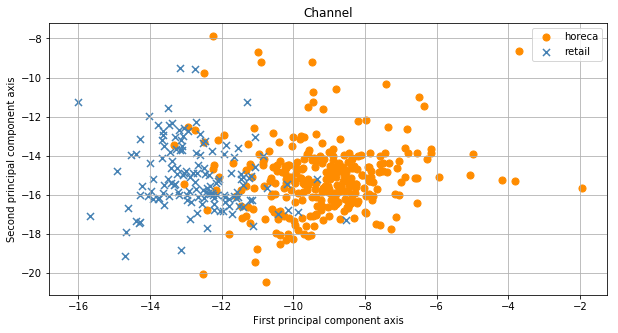

In [25]:
plt.figure(figsize =(10,5))
plt.title('Channel')

data_horeca= data_pca[data_original["Channel"]==1]
data_retail = data_pca[data_original["Channel"]==2]

plt.scatter(data_horeca[:,0], data_horeca[:,1], marker='o', color= 'darkorange', s=50, label='horeca')
plt.scatter(data_retail[:,0], data_retail[:,1], marker='x', color='steelblue', s=50, label='retail')

plt.grid()
# plt.hold(True)
# centroid = np.dot(km.cluster_centers_, pca_vector.T)
# plt.plot(centroid[:,0], centroid[:,1], "*", MarkerSize =20, MarkerFaceColor = 'r', MarkerEdgeColor = 'r')
plt.xlabel("First principal component axis")
plt.ylabel("Second principal component axis")
plt.legend()
plt.show()

クラスタリングしたグループと地域と業種で第一主成分、第二主成分でプロットした場合、

**クラスタリングしたグループと業種**が近い傾向が見られる。

これを詳しく見ていく。

In [26]:
data_y_km =pd.concat([data_original,pd.DataFrame(y_km)],axis=1)

各データごとに合計金額を表す'TotalPrice'を計算し、特徴量として加える。

In [27]:
data_y_km['TotalPrice']= data_y_km['Fresh']+data_y_km['Milk']+data_y_km['Grocery']+\
                                               data_y_km['Frozen']+data_y_km['Detergents_Paper']+data_y_km['Delicassen']

In [28]:
data_original['TotalPrice']= data_original['Fresh']+data_original['Milk']+data_original['Grocery']+\
                                               data_original['Frozen']+data_original['Detergents_Paper']+data_original['Delicassen']

In [29]:
df_group0 = data_y_km[data_y_km[0] == 0].describe()
df_group1 = data_y_km[data_y_km[0] == 1].describe()
df_group0 = df_group0.drop(0, axis=1).loc['mean','Fresh':]
df_group1 = df_group1.drop(0, axis=1).loc['mean','Fresh':]

In [30]:
data_original['TotalPrice']= data_original['Fresh']+data_original['Milk']+data_original['Grocery']+\
                                               data_original['Frozen']+data_original['Detergents_Paper']+data_original['Delicassen']
df_horeca=data_original[data_original['Channel']==1].describe()
df_retail=data_original[data_original['Channel']==2].describe()
df_horeca = df_horeca.loc['mean','Fresh':]
df_retail = df_retail.loc['mean','Fresh':]

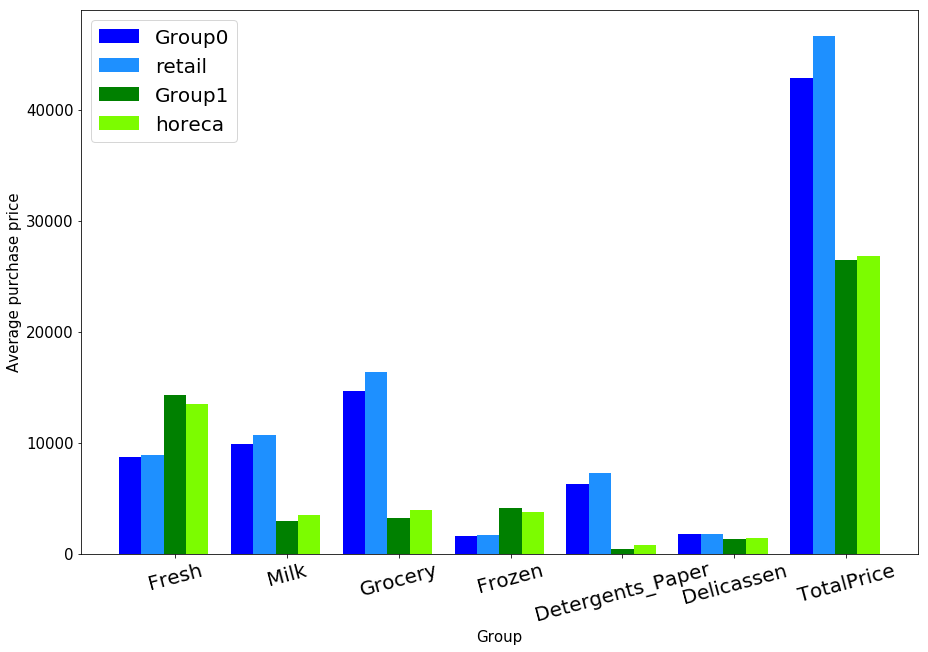

In [31]:
# plt.figure(figsize=(20,20))

plt.figure(figsize=(15,10))

X1=[0,1.5,3.0,4.5,6.0,7.5,9.0]
width = [0.3,0.3,0.3,0.3,0.3,0.3,0.3]
X2 = list(np.array(X1)+np.array(width))
X3 = list(np.array(X2)+np.array(width))
X4 = list(np.array(X3)+np.array(width))

plt.bar(X1, df_group0, color='b', width=0.3, label='Group0')
plt.bar(X2,df_retail, color='dodgerblue', width=0.3, label='retail')
plt.bar(X3,df_group1, color='g', width=0.3, label='Group1')
plt.bar(X4,df_horeca, color='lawngreen', width=0.3, label='horeca')

# 凡例
plt.legend(loc=2, fontsize=20)

# X軸の目盛りを置換
plt.xticks(list(np.array(X1)+np.array(width)*2), list(data_original.columns[2:]), fontsize = 20, rotation=15)
plt.yticks(fontsize = 15)
plt.xlabel("Group", fontsize=15)
plt.ylabel("Average purchase price", fontsize=15)
plt.show()

それぞれの商品カテゴリーの平均金額でグループと業種で見た場合、

グループ０と小売店、グループ１とhorecaが同じような傾向があることが分かる。

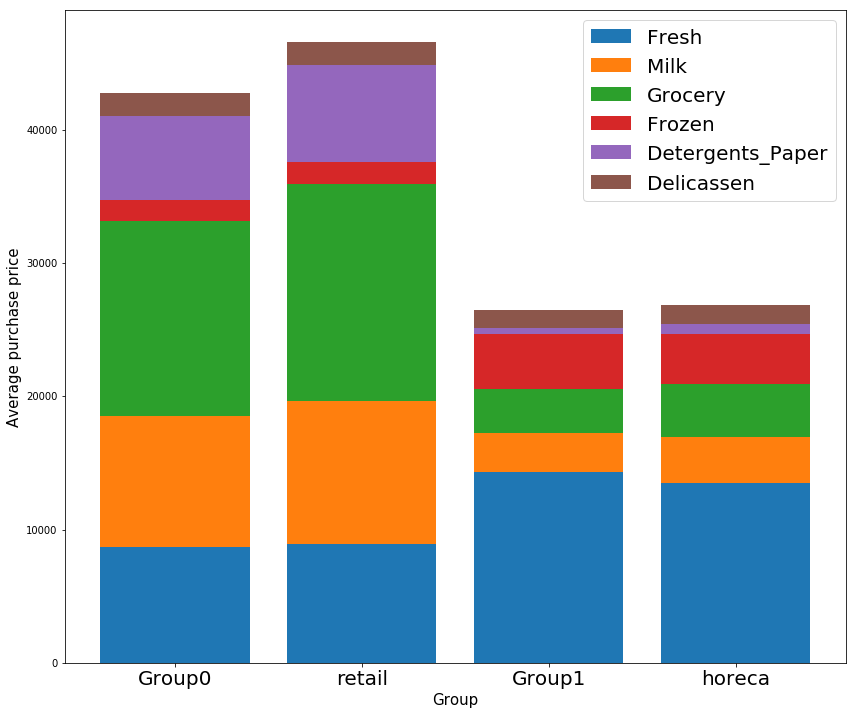

In [32]:
plt.figure(figsize=(14,12))

data = []
bar = []
colors = ['b', 'teal', 'y', 'c', 'darkorange', 'pick']
positions = range(1, 5) #x軸の位置
len_column  = 6#len(df_group0.columns)
for i in range(len_column):
    data.append(np.array([df_group0[i], df_retail[i], df_group1[i], df_horeca[i]]))
    bottom = np.array([.0, .0, .0, .0])
    for j in range(i):
        bottom += data[j]
    bottom
    if i == 0:
        bar.append(plt.bar(positions, data[i], align = 'center'))
    else:
        bar.append(plt.bar(positions, data[i], align = 'center', bottom = bottom))  #,  color= colors[i]))
    
x_labels = ['Group0', 'retail', 'Group1','horeca'] #x軸に表示するラベル

plt.xticks(positions, x_labels,fontsize=20) #x軸の値の変更
# plt.ylim(0, 30000) #y軸の表示範囲 
plt.legend((bar),('Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'),fontsize=20) #凡例の表示
plt.style.use('ggplot')
plt.xlabel("Group", fontsize=15)
plt.ylabel("Average purchase price", fontsize=15)
plt.show() #グラフの表示

クラスタリングしたグループとChannelの購入の内訳を見ても同じような傾向がある。

## 卸売業者への報告

- 分析したグループと業種が近い傾向があった。
- 小売店はhoreca(ホテル　レストラン　カフェ）より顧客単価が1.7倍高い。
- 小売店はミルク、食料品、洗剤と紙類がよく売れる傾向がある。
- horeca(ホテル　レストラン　カフェ）は生鮮食品と冷凍食品がよく売れる傾向がある。
- 販売傾向は地域によっては分けられず業種によって変わる。ー＞**別の地域に進出する場合は取引業種の割合で用意する在庫を調整すればよい。**

### おまけ

第一主成分のベクトルで値が大きい、Milk、Fresh、Detergents_Paperを軸として、
- クラスター０，１
- 小売とhoreca(ホテル、レストラン、カフェ)
を三次元で描画してみた。

主成分の重みが大きい軸を選択しているので第一主成分軸でみたときと同じような見た目になっている。

※当初は見栄えがよいかと思ったが、ここで言いたいことは主成分軸でプロットした結果と同じことを言っているため説明としては省きました。

In [33]:
pca_vector[0]

array([ 0.17371704, -0.394463  , -0.45436364,  0.17219603, -0.74551495,
       -0.1494356 ])

<IPython.core.display.Javascript object>


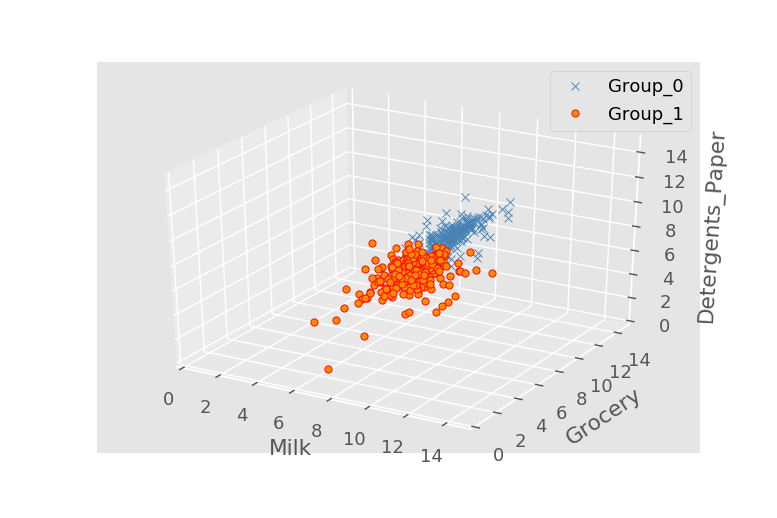

In [36]:
from mpl_toolkits.mplot3d import Axes3D
from scipy import genfromtxt
%matplotlib notebook

# グラフ作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# 軸ラベルの設定
ax.set_xlabel("Milk")
ax.set_ylabel("Grocery")
ax.set_zlabel("Detergents_Paper")

# 表示範囲の設定
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)
ax.set_zlim(0, 15)

# 抽出条件設定
data_zero = data_fs[y_km==0]
data_one = data_fs[y_km==1]


# グラフ描画
ax.plot(data_zero['Milk'], data_zero['Grocery'], data_zero["Detergents_Paper"], "x", color="steelblue", ms=4, mew=0.5, label='Group_0')
ax.plot(data_one['Milk'], data_one['Grocery'], data_one["Detergents_Paper"], "o", MarkerEdgeColor = 'r', color="darkorange", ms=4, mew=0.5, label='Group_1')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


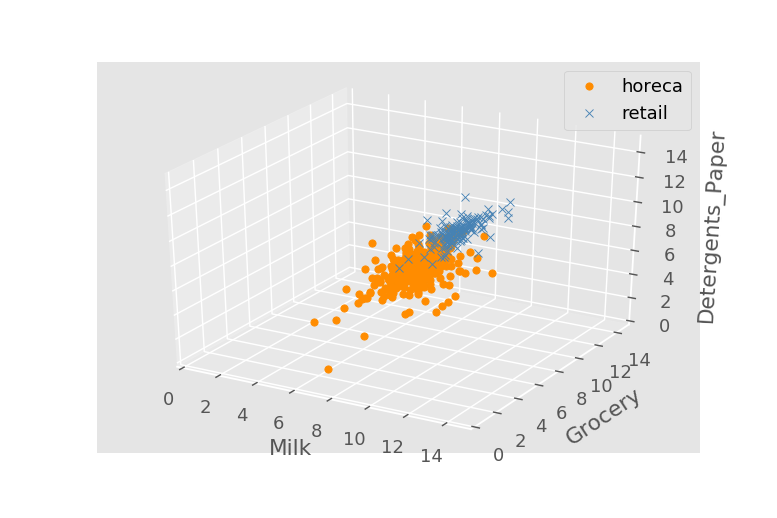

In [37]:
# グラフ作成
fig = plt.figure()
plt.title('Channel')
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルの設定
ax.set_xlabel("Milk")
ax.set_ylabel("Grocery")
ax.set_zlabel("Detergents_Paper")

# 表示範囲の設定
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)
ax.set_zlim(0, 15)

# 抽出条件設定
data_horeca= data_fs[data_original["Channel"]==1]
data_retail = data_fs[data_original["Channel"]==2]

# グラフ描画
#ax.plot(data_zero['Milk'], data_zero['Grocery'], data_zero["Detergents_Paper"], "x", color="steelblue", ms=4, mew=0.5, label='Group_0')
ax.plot(data_horeca['Milk'], data_horeca['Grocery'], data_horeca["Detergents_Paper"], 'o', color= 'darkorange', ms=4, mew=0.5, label='horeca')
ax.plot(data_retail['Milk'], data_retail['Grocery'], data_retail["Detergents_Paper"], 'x', color='steelblue', ms=4, mew=0.5, label='retail') # "o", MarkerEdgeColor = 'r', color="darkorange", ms=4, mew=0.5, label='data_retail')
plt.legend()
plt.show()